## Storage Forecasting

In [ ]:
# Install dependencies
%pip install kats

### Data Prepartion
Last 3 years data from InfluxDB has been used for this work. It was observed that there were missing dates and few other misc issues hence we had to prepare the data before applying any forecasting model on the dataset.

In [39]:
import pandas as pd
# Load the data into a Pandas dataframe
df = pd.read_csv('daily_storage_data.csv', index_col='Date', parse_dates=True)

# Noticed duplicates somewhere hence dropping those
df.drop_duplicates(inplace=True)

# Resample the data at daily frequency and fill missing values
df = df.resample('D').mean().interpolate()

# Reset the index to have the date column as a regular column
df = df.reset_index()

df.head()

,Date,Storage
0,2020-03-28,2.364111
1,2020-03-29,2.364089
2,2020-03-30,2.364086
3,2020-03-31,2.366105
4,2020-04-01,2.372844


### Turn Data into Time Series 
[Kats](https://facebookresearch.github.io/Kats/) is a time series library from Meta. The API seemed to be user friendly and it had most of the models covered. Hence, we chose this library for our work.

In [40]:
from kats.consts import TimeSeriesData
import matplotlib.pyplot as plt
import warnings
import sys

warnings.simplefilter(action='ignore')
sys.path.append("../")

# Set chart size
plt.rcParams["figure.figsize"] = (12,5)

# Convert the dataframe into a Kats TimeSeriesData object
data = TimeSeriesData(df, time='Date', value='Storage', time_col_name='Date')

# Split the data into train and test sets
train_data = TimeSeriesData(df[(df['Date'] < "2022-06-01")], time='Date', value='Storage', time_col_name='Date')
test_data = TimeSeriesData(df[(df['Date'] > "2022-06-01")], time='Date', value='Storage', time_col_name='Date')



### Forecasting
We will apply the following time series models on our dataset.
- Prophet
- Holt-Winters
- SARIMA

#### Prophet Model

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -5.04629
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99        3456.5     0.0227044       4120.61      0.4167           1      126   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       3526.52    0.00927374       1632.33           1           1      238   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       3611.75   0.000670086       802.433           1           1      351   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       3626.83     0.0011683       1844.83           1           1      463   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       3649.11    0.00429526       1021.14           1           1      576   
    Iter      log prob        ||dx||      ||grad||       alpha  

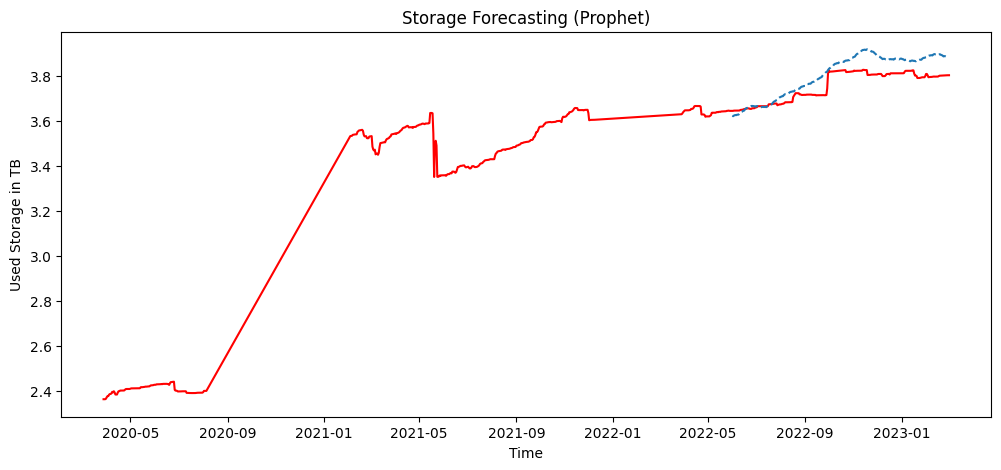

In [41]:
from kats.models.prophet import ProphetModel, ProphetParams

# Define the Prophet parameters
params = ProphetParams(seasonality_mode='multiplicative', seasonality_prior_scale=0.01)


# Initialize and fit a Prophet model using the training data
model = ProphetModel(train_data, params)
model.fit()

# Make a forecast for the next n days
forecast = model.predict(len(test_data))

# Plot the forecast and the actual data
# model.plot()
plt.plot(df['Date'], df['Storage'], label='Actual', color='r')
plt.plot(forecast['time'], forecast['fcst'], label='Forecast', linestyle='--')
plt.title("Storage Forecasting (Prophet)")
plt.xlabel("Time")
plt.ylabel("Used Storage in TB")
plt.show()

#### Holt-Winters Model

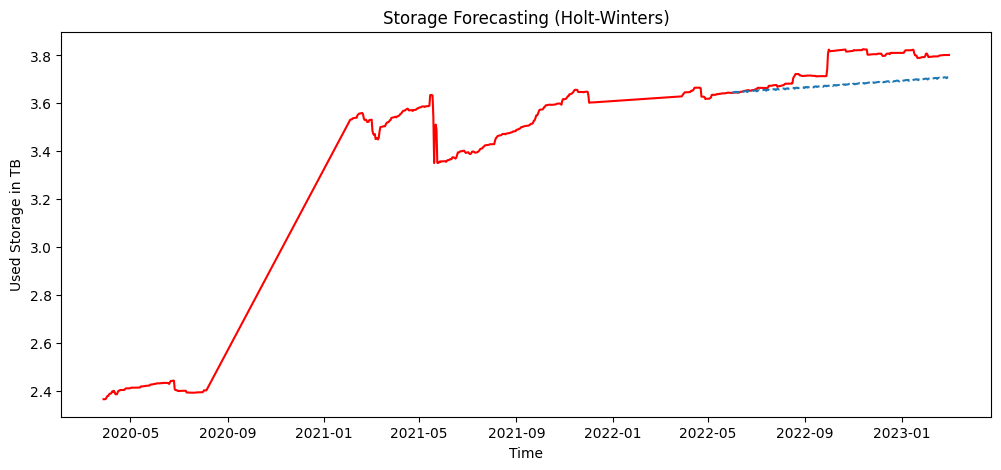

In [42]:
from kats.models.holtwinters import HoltWintersModel, HoltWintersParams

params = HoltWintersParams(
    trend='additive',
    seasonal='multiplicative',
    seasonal_periods=12,
)

model = HoltWintersModel(data=train_data, params=params)
model.fit()

forecast = model.predict(steps=len(test_data))


plt.plot(df['Date'], df['Storage'], label='Actual', color='r')
plt.plot(forecast['time'], forecast['fcst'], label='Forecast', linestyle='--')
plt.title("Storage Forecasting (Holt-Winters)")
plt.xlabel("Time")
plt.ylabel("Used Storage in TB")
plt.show()

#### SARIMA Model

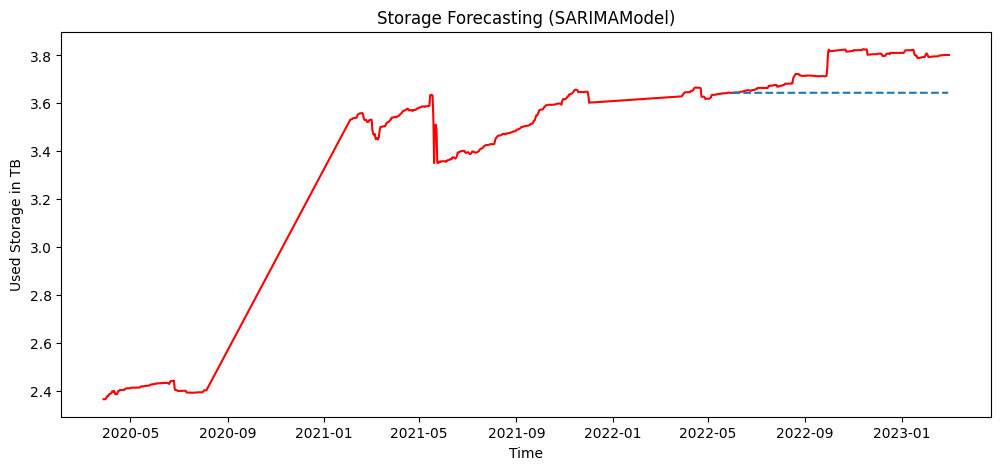

In [43]:
from kats.models.sarima import SARIMAModel, SARIMAParams

# Define the SARIMA parameters
params = SARIMAParams(p=1, d=1, q=1, seasonal_order=(1, 0, 1, 12))

# Fit the SARIMA model to the training data
sarima_model = SARIMAModel(data=train_data, params=params)
sarima_model.fit()

# Generate predictions for the testing set
forecast = sarima_model.predict(steps=len(test_data))

# Plot the actual data and the predicted values
plt.plot(df['Date'], df['Storage'], label='Actual', color='r')
plt.plot(forecast['time'], forecast['fcst'], label='Forecast', linestyle='--')
plt.title(f"Storage Forecasting ({sarima_model.__class__.__name__})")
plt.xlabel("Time")
plt.ylabel("Used Storage in TB")
plt.show()

#### LSTM

In [38]:
from kats.consts import TimeSeriesData
from kats.models.lstm import LSTMModel, LSTMParams


# Define the LSTM model parameters
params = LSTMParams(
    # input_dim=1,
    # output_size=1,
    hidden_size=32,
    time_window=len(test_data),
    # num_layers=2,
    # dropout_rate=0.2,
    # seq_len=24,
    # learning_rate=0.001,
    num_epochs=len(train_data),
    # batch_size=64
)

# Create an instance of the LSTM model
lstm_model = LSTMModel(
    data=train_data,
    params=params
)

# Train the LSTM model
lstm_model.fit()

# Make predictions with the trained model
forecast = lstm_model.predict(steps=len(test_data))




KeyboardInterrupt: 

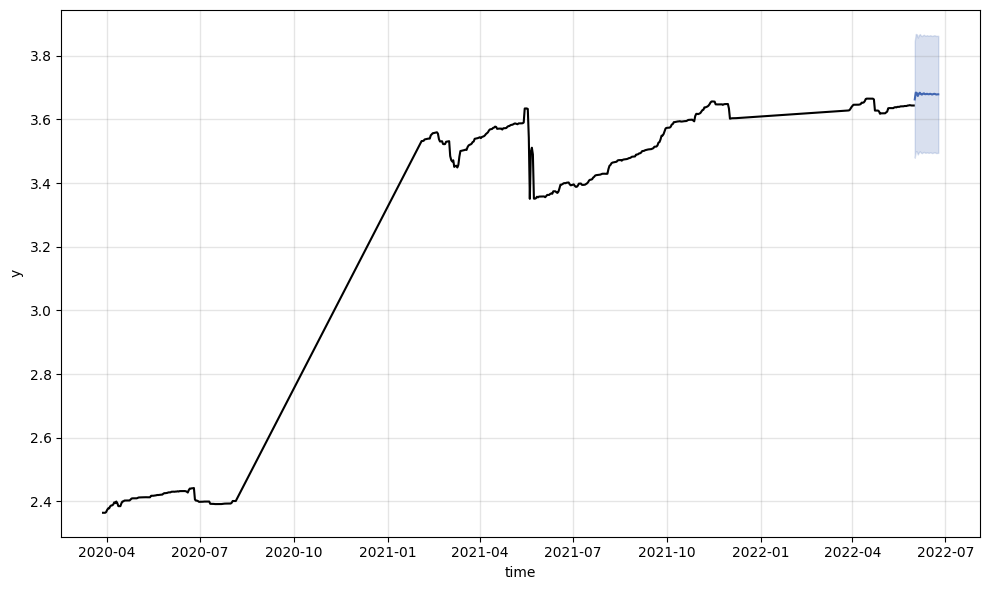

In [37]:
lstm_model.plot()